In [1]:
from pca_items.intrinsic_dimension import IntrinsicDimensionRMT as ID

In [2]:
from visuals import WAVELENGTHS
from pca_helper import *

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [4]:
import concurrent

In [5]:
def thread_id(s):
    i, series = s[0], s[1]
    print("Starting Series: ", i+1)
    this_mat = np.array(series['data'])

    this_noise = corrected_noise
    for j in range(i):
        this_noise = np.concatenate([this_noise, corrected_noise], axis=0)    
    this_n_est = {'noise_covariance':np.diag(this_noise), 'estimation_method': 'MultipleRegressionClassicNoiseEstimator'} 
    
    instrinsic_dimension = ID()
    _id = instrinsic_dimension(this_mat, this_n_est)
    print(f"Series: {i+1} ID: {_id['intrinsic_dimension']}")
    return (i, _id)
    
def thread_series(series_dict):
    id_series = []
    with concurrent.futures.ThreadPoolExecutor() as executer:
        series = [(i, s) for i, s in enumerate(series_dict)]

        results = executer.map(thread_id, series)

        for result in results:
            id_series.append(result)
            
        s = sorted(id_series, key=lambda x: x[0])
        r = [j for i,j in s]
        return r


In [6]:
wl = np.array(WAVELENGTHS)
cond_1_2 = ((wl > 1760) & (wl < 1840))
cond_2_2 = ((wl > 1480) & (wl < 1760))
cond_3_2 = ((wl > 1930) & (wl < 2450))
cond_4_2 = (wl < 1280)
indicies = np.where(cond_1_2 | cond_2_2 | cond_3_2 | cond_4_2)

def create_series(dates_list, series_dict):
    series = []
    remove_bands = True

    for dates, mean_freq in dates_list:
        master = None
        for d in dates:
            ds = series_dict[d]
            if remove_bands:
                # ds = remove_bands_f(ds) 
                ds = ds[:,indicies[0]] # IMPORTANT REMOVE THIS WHEN NOT RUNNING ON NWE NOISE MATRIX

            if master is None:
                master = ds
            else:
                master = np.concatenate([master, ds], axis=1)
        series.append({'dates':dates, 'mean_frequency':mean_freq, 'data':master})
    
    return series

In [7]:
def nan_indicies(series):
    nan_inds = []
    for i in range(series[-1]['data'].shape[0]):
        if -9999 in list(series[-1]['data'][i]):
            nan_inds.append(i)
            
    print(nan_inds)
    return nan_inds

def remove_nans(series):
    nan_inds = nan_indicies(series)
    
    for s in series:
        s['data'] = np.delete(np.array(s['data']), nan_inds, axis=0)
        
    return series

In [8]:
noise = np.genfromtxt('RMT_debugging_N.csv', delimiter=',')
corrected_noise = np.array([noise[i][i] for i in range(len(noise))])

In [25]:
with open("/home/makiper/Notebooks/true_parking_lot_rfls.pickle", "rb") as f:
    temp_dict = pickle.load(f)

num_dates = len(temp_dict.keys())
series_dates = [create_raw_time_series(temp_dict, i, remove_bands=False) for i in range(num_dates)] # water bands already removed

  Real Date  |  Desired Optimal Date  |  Difference
2022-02-24 00:00:00 | 2022-02-24 00:00:00 | 0
  Real Date  |  Desired Optimal Date  |  Difference
2022-02-24 00:00:00 | 2022-02-24 00:00:00 | 0
2022-05-29 00:00:00 | 2022-05-29 00:00:00 | 0
  Real Date  |  Desired Optimal Date  |  Difference
2022-02-24 00:00:00 | 2022-02-24 00:00:00 | 0
2022-04-12 00:00:00 | 2022-04-12 00:00:00 | 0
2022-05-29 00:00:00 | 2022-05-29 00:00:00 | 0
  Real Date  |  Desired Optimal Date  |  Difference
2022-02-24 00:00:00 | 2022-02-24 00:00:00 | 0
2022-03-22 00:00:00 | 2022-03-27 00:00:00 | 5
2022-04-29 00:00:00 | 2022-04-27 00:00:00 | 2
2022-05-29 00:00:00 | 2022-05-29 00:00:00 | 0
  Real Date  |  Desired Optimal Date  |  Difference
2022-02-24 00:00:00 | 2022-02-24 00:00:00 | 0
2022-03-16 00:00:00 | 2022-03-19 00:00:00 | 3
2022-04-12 00:00:00 | 2022-04-12 00:00:00 | 0
2022-05-03 00:00:00 | 2022-05-05 00:00:00 | 2
2022-05-29 00:00:00 | 2022-05-29 00:00:00 | 0
  Real Date  |  Desired Optimal Date  |  Differenc

/home/brodrick/miniconda/envs/emit/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/brodrick/miniconda/envs/emit/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [149]:
def spectral_angle(a, b):
    a, b = np.array(a), np.array(b)
    if a.shape != b.shape:
        raise Exception("shape mismatch")
        
    def l2_norm(x):
        return sum([i**2 for i in x])**0.5
    
    inner = (a.T@b)/(l2_norm(a)*l2_norm(b))
    return np.arccos(inner)

In [156]:
np.mean(parking_lot_dict['20220224'], axis=0).shape

(425,)

In [37]:
# try with veg

In [5]:
import pandas as pd

veg_data = pd.read_csv('export_for_mk.csv')
veg_types = np.unique(veg_data['Plot Type'])
veg_types

array(['Grassland', 'Shrub', 'Tree'], dtype=object)

In [6]:
grassland = veg_data[veg_data['Plot Type'] == 'Grassland']
shrub = veg_data[veg_data['Plot Type'] == 'Shrub']
tree = veg_data[veg_data['Plot Type'] == 'Tree']

In [7]:
def geocoords(file):
    transform = file.GetGeoTransform()

    x_origin = transform[0]
    y_origin = transform[3]
    pixel_width = transform[1]
    pixel_height = -transform[5]
    return x_origin, y_origin, pixel_width, pixel_height

def geotransform(geocoords, x, y):
    x_origin, y_origin, pixel_width, pixel_height = geocoords
    return int((x - x_origin)/pixel_width), int((y_origin - y)/pixel_height)

gdals = []
all_gcoords = []
dates = ['20220224', '20220228', '20220308', '20220316', '20220322', '20220405', '20220412', '20220420', '20220429', '20220503', '20220511', '20220517', '20220529']
for date in dates:
    f = gdal.Open(f"/beegfs/scratch/makiper/Mosaics/flight_products/{date}/box_mosaics/box_rfl_phase_l2a")
    gcoords = geocoords(f)
    gdals.append(f)
    all_gcoords.append(gcoords)

def get_rfls(dataframe):
    num_coords = len(dataframe.index)
    step = 3
    
    date_dict = dict(zip(dates, [[] for d in dates]))

    for pix in range(num_coords):
        this_x_utm, this_y_utm = dataframe.iloc[pix]['center_x_utm'], dataframe.iloc[pix]['center_y_utm']
        print("%: ", np.round(pix/num_coords*100, 2))

        for i, date in enumerate(dates):
            f = gdals[i]
            gcoords = all_gcoords[i]

            x, y = geotransform(gcoords, this_x_utm, this_y_utm)


            rfl = f.ReadAsArray(xoff=x-1, yoff=y+1, xsize=step, ysize=step)
            rfl = np.array(rfl).T
            rfl = np.fliplr(rfl)
            rfl = np.rot90(rfl, k=1, axes=(0,1))

            for j in range(step):
                for k in range(step):
                    date_dict[date].append(rfl[j][k])
    return date_dict

In [8]:
def create_series_veg(dates, rfls):
    remove_bands = True
    series = []

    for dates, mean_freq in dates:
        master = None
        for d in dates:
            ds = np.array(rfls[d])
            if remove_bands:
                    # ds = remove_bands_f(ds)
                    ds = ds[:,indicies[0]] # IMPORTANT REMOVE THIS WHEN NOT RUNNING ON NWE NOISE MATRIX

            if master is None:
                master = ds
            else:
                master = np.concatenate([master, ds], axis=1)
        series.append({'dates':dates, 'mean_frequency':mean_freq, 'data':master})
        
    return series

In [9]:
grassland_rfls = get_rfls(grassland)

%:  0.0
%:  2.0
%:  4.0
%:  6.0
%:  8.0
%:  10.0
%:  12.0
%:  14.000000000000002
%:  16.0
%:  18.0
%:  20.0
%:  22.0
%:  24.0
%:  26.0
%:  28.000000000000004
%:  30.0
%:  32.0
%:  34.0
%:  36.0
%:  38.0
%:  40.0
%:  42.0
%:  44.0
%:  46.0
%:  48.0
%:  50.0
%:  52.0
%:  54.0
%:  56.00000000000001
%:  57.99999999999999
%:  60.0
%:  62.0
%:  64.0
%:  66.0
%:  68.0
%:  70.0
%:  72.0
%:  74.0
%:  76.0
%:  78.0
%:  80.0
%:  82.0
%:  84.0
%:  86.0
%:  88.0
%:  90.0
%:  92.0
%:  94.0
%:  96.0
%:  98.0


In [10]:
for date in grassland_rfls.keys():
    grassland_rfls[date] = np.array(grassland_rfls[date])

In [15]:
band_ranges = [(1340, 1460), (1800, 2050), 2450, 400]
wl = np.array(WAVELENGTHS)
cond_1 = ((wl > band_ranges[0][0]) & (wl < band_ranges[0][1]))
cond_2 = ((wl > band_ranges[1][0]) & (wl < band_ranges[1][1]))
cond_3 = (wl > band_ranges[2])
cond_4 = (wl < band_ranges[3])
bad_indicies = np.where(cond_1 | cond_2 | cond_3 | cond_4)

In [16]:
indicies = [i for i in range(425) if i not in list(bad_indicies[0])]

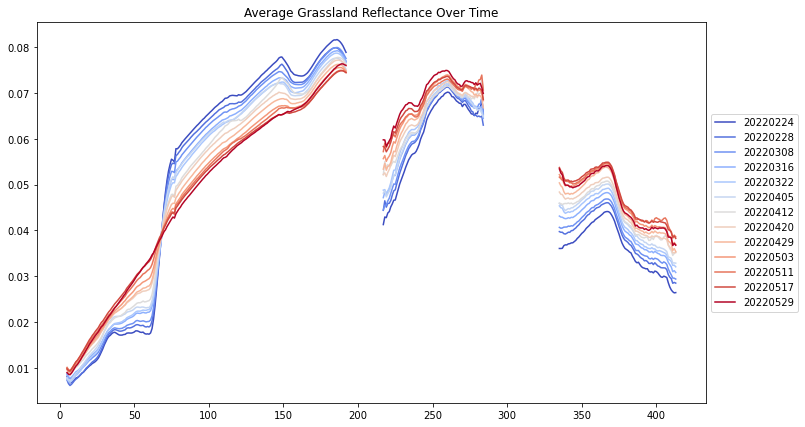

In [14]:
colors = plt.cm.coolwarm(np.linspace(0,1,len(grassland_rfls.keys())))

c_i = 0

fig = plt.figure(figsize=(12,7))
for date, data in grassland_rfls.items():    
    ds = data.copy()
    
    bad_rfls = []
    for i, rfl in enumerate(ds):
        if -9999 in list(rfl):
            bad_rfls.append(i)
    ds = np.delete(ds, bad_rfls, axis=0)
        
    mean = np.mean(ds, axis=0)
    if np.mean(mean)<0:
        print(date)
    mean[bad_indicies] = np.nan
    mean = mean/(sum([i**2 for i in mean if not np.isnan(i)])**0.5)
    plt.plot(mean, c = colors[c_i], label = date);
    c_i += 1
    
plt.title("Average Grassland Reflectance Over Time")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

In [15]:
with open('true_grassland_rfls.pickle', 'wb') as f:
    pickle.dump(grassland_rfls, f)

In [16]:
shrub_rfls = get_rfls(shrub)

%:  0.0
%:  1.72
%:  3.45
%:  5.17
%:  6.9
%:  8.62
%:  10.34
%:  12.07
%:  13.79
%:  15.52
%:  17.24
%:  18.97
%:  20.69
%:  22.41
%:  24.14
%:  25.86
%:  27.59
%:  29.31
%:  31.03
%:  32.76
%:  34.48
%:  36.21
%:  37.93
%:  39.66
%:  41.38
%:  43.1
%:  44.83
%:  46.55
%:  48.28
%:  50.0
%:  51.72
%:  53.45
%:  55.17
%:  56.9
%:  58.62
%:  60.34
%:  62.07
%:  63.79
%:  65.52
%:  67.24
%:  68.97
%:  70.69
%:  72.41
%:  74.14
%:  75.86
%:  77.59
%:  79.31
%:  81.03
%:  82.76
%:  84.48
%:  86.21
%:  87.93
%:  89.66
%:  91.38
%:  93.1
%:  94.83
%:  96.55
%:  98.28


In [17]:
for date in shrub_rfls.keys():
    shrub_rfls[date] = np.array(shrub_rfls[date])

In [18]:
with open('true_shrub_rfls.pickle', 'wb') as f:
    pickle.dump(shrub_rfls, f)

In [13]:
with open('true_shrub_rfls.pickle', 'rb') as f:
    shrub_rfls = pickle.load(f)

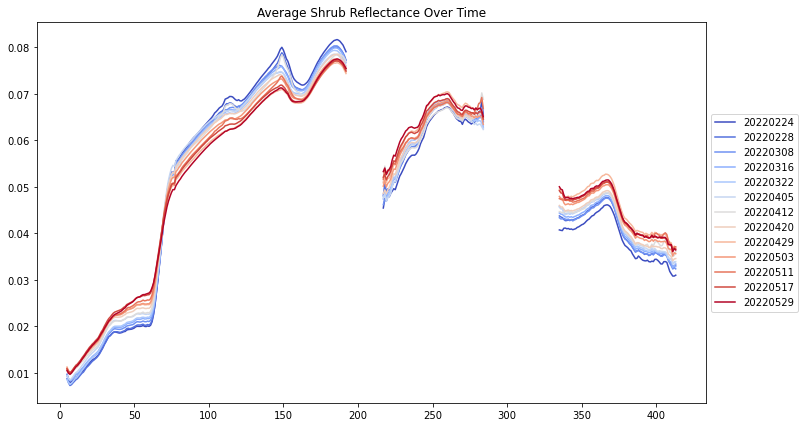

In [17]:
colors = plt.cm.coolwarm(np.linspace(0,1,len(shrub_rfls.keys())))

c_i = 0

fig = plt.figure(figsize=(12,7))
for date, data in shrub_rfls.items():    
    ds = data.copy()
    
    bad_rfls = []
    for i, rfl in enumerate(ds):
        if -9999 in list(rfl):
            bad_rfls.append(i)
    ds = np.delete(ds, bad_rfls, axis=0)
        
    mean = np.mean(ds, axis=0)
    if np.mean(mean)<0:
        print(date)
    mean[bad_indicies] = np.nan
    mean = mean/(sum([i**2 for i in mean if not np.isnan(i)])**0.5)
    plt.plot(mean, c = colors[c_i], label = date);
    c_i += 1
    
plt.title("Average Shrub Reflectance Over Time")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

In [9]:
tree_rfls = get_rfls(tree)

%:  0.0
%:  0.6
%:  1.2
%:  1.8
%:  2.4
%:  2.99
%:  3.59
%:  4.19
%:  4.79
%:  5.39
%:  5.99
%:  6.59
%:  7.19
%:  7.78
%:  8.38
%:  8.98
%:  9.58
%:  10.18
%:  10.78
%:  11.38
%:  11.98
%:  12.57
%:  13.17
%:  13.77
%:  14.37
%:  14.97
%:  15.57
%:  16.17
%:  16.77
%:  17.37
%:  17.96
%:  18.56
%:  19.16
%:  19.76
%:  20.36
%:  20.96
%:  21.56
%:  22.16
%:  22.75
%:  23.35
%:  23.95
%:  24.55
%:  25.15
%:  25.75
%:  26.35
%:  26.95
%:  27.54
%:  28.14
%:  28.74
%:  29.34
%:  29.94
%:  30.54
%:  31.14
%:  31.74
%:  32.34
%:  32.93
%:  33.53
%:  34.13
%:  34.73
%:  35.33
%:  35.93
%:  36.53
%:  37.13
%:  37.72
%:  38.32
%:  38.92
%:  39.52
%:  40.12
%:  40.72
%:  41.32
%:  41.92
%:  42.51
%:  43.11
%:  43.71
%:  44.31
%:  44.91
%:  45.51
%:  46.11
%:  46.71
%:  47.31
%:  47.9
%:  48.5
%:  49.1
%:  49.7
%:  50.3
%:  50.9
%:  51.5
%:  52.1
%:  52.69
%:  53.29
%:  53.89
%:  54.49
%:  55.09
%:  55.69
%:  56.29
%:  56.89
%:  57.49
%:  58.08
%:  58.68
%:  59.28
%:  59.88
%:  60.48
%:  61.08


In [10]:
for date in tree_rfls.keys():
    tree_rfls[date] = np.array(tree_rfls[date])

In [11]:
with open('true_tree_rfls.pickle', 'wb') as f:
    pickle.dump(tree_rfls, f)

In [19]:
with open('true_tree_rfls.pickle', 'rb') as f:
    tree_rfls = pickle.load(f)

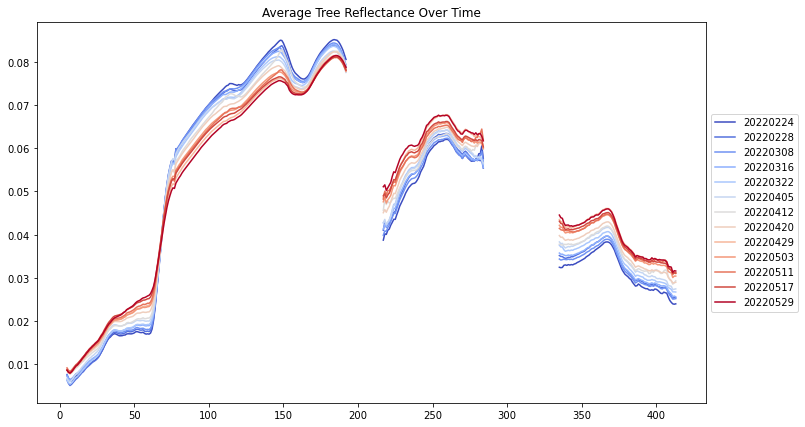

In [18]:
colors = plt.cm.coolwarm(np.linspace(0,1,len(tree_rfls.keys())))

c_i = 0

fig = plt.figure(figsize=(12,7))
for date, data in tree_rfls.items():    
    ds = data.copy()
    
    bad_rfls = []
    for i, rfl in enumerate(ds):
        if -9999 in list(rfl):
            bad_rfls.append(i)
    ds = np.delete(ds, bad_rfls, axis=0)
        
    mean = np.mean(ds, axis=0)
    if np.mean(mean)<0:
        print(date)
    mean[bad_indicies] = np.nan
    mean = mean/(sum([i**2 for i in mean if not np.isnan(i)])**0.5)
    plt.plot(mean, c = colors[c_i], label = date);
    c_i += 1
    
plt.title("Average Tree Reflectance Over Time")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

In [12]:
# with open("parking_lot_id.pickle", "rb") as f:
#     parking_lot_id = pickle.load(f)
    
# with open("roof_top_id.pickle", "rb") as f:
#     roof_top_id = pickle.load(f)
    
# with open("rock_id.pickle", "rb") as f:
#     rock_id = pickle.load(f)
    
with open("parking_lot_id_new_noise_2.pickle", "rb") as f:
    parking_lot_id = pickle.load(f)
    
with open("roof_top_id_new_noise_2.pickle", "rb") as f:
    roof_top_id = pickle.load(f)
    
with open("rock_id_new_noise_2.pickle", "rb") as f:
    rock_id = pickle.load(f)

In [13]:
with open("grassland_id_new_noise_2.pickle", "rb") as f:
    grassland_id = pickle.load(f)
    
with open("shrub_id_new_noise_2.pickle", "rb") as f:
    shrub_id = pickle.load(f)
    
with open("tree_id_new_noise_2.pickle", "rb") as f:
    tree_id = pickle.load(f)

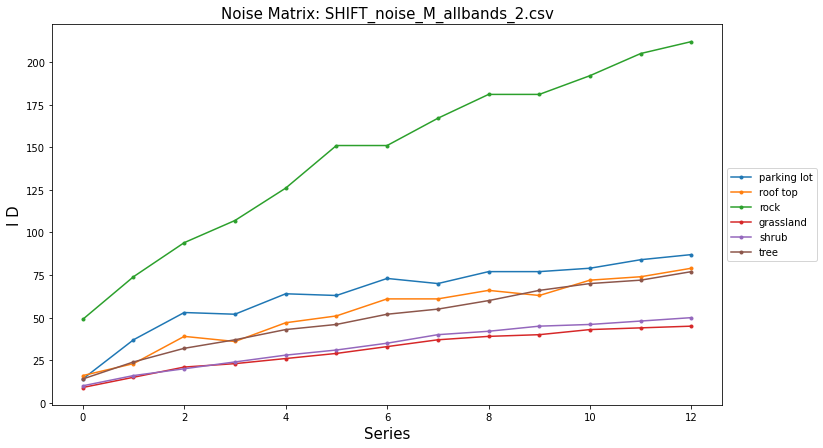

In [14]:
figure= plt.figure(figsize=(12, 7))

plt.plot([i['intrinsic_dimension'] for i in parking_lot_id], marker='.', label='parking lot');
plt.plot([i['intrinsic_dimension'] for i in roof_top_id], marker='.', label='roof top');
plt.plot([i['intrinsic_dimension'] for i in rock_id], marker='.', label='rock');
plt.plot([i['intrinsic_dimension'] for i in grassland_id], marker='.', label='grassland');
plt.plot([i['intrinsic_dimension'] for i in shrub_id], marker='.', label='shrub');
plt.plot([i['intrinsic_dimension'] for i in tree_id], marker='.', label='tree');

plt.xlabel('Series', fontsize=15);
plt.ylabel('I D', fontsize=15);
plt.title("Noise Matrix: SHIFT_noise_M_allbands_2.csv", fontsize=15);
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

In [32]:
# with open("parking_lot_id_old_noise.pickle", "rb") as f:
#     parking_lot_id_old_noise = pickle.load(f)
    
# with open("roof_top_id_old_noise.pickle", "rb") as f:
#     roof_top_id_old_noise = pickle.load(f)
    
# with open("rock_id_old_noise.pickle", "rb") as f:
#     rock_id_old_noise = pickle.load(f)

# with open("parking_lot_id_old_noise_2_corrected.pickle", "rb") as f:
#     parking_lot_id_old_noise = pickle.load(f)
    
# with open("roof_top_id_old_noise_2_corrected.pickle", "rb") as f:
#     roof_top_id_old_noise = pickle.load(f)
    
# with open("rock_id_old_noise_2_corrected.pickle", "rb") as f:
#     rock_id_old_noise = pickle.load(f)

# This version has the taken out z-scores

with open("parking_lot_id_old_noise_3.pickle", "rb") as f:
    parking_lot_id_old_noise = pickle.load(f)
    
with open("roof_top_id_old_noise_3.pickle", "rb") as f:
    roof_top_id_old_noise = pickle.load(f)
    
with open("rock_id_old_noise_3.pickle", "rb") as f:
    rock_id_old_noise = pickle.load(f)

In [33]:
with open("grassland_id_old_noise.pickle", "rb") as f:
    grassland_id_old_noise = pickle.load(f)
    
with open("shrub_id_old_noise.pickle", "rb") as f:
    shrub_id_old_noise = pickle.load(f)
    
with open("tree_id_old_noise.pickle", "rb") as f:
    tree_id_old_noise = pickle.load(f)

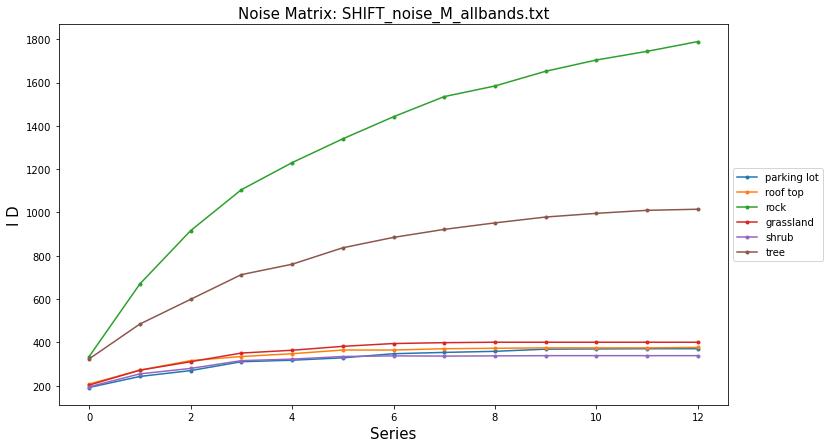

In [35]:
figure= plt.figure(figsize=(12, 7))

plt.plot([i['intrinsic_dimension'] for i in parking_lot_id_old_noise], marker='.', label='parking lot');
plt.plot([i['intrinsic_dimension'] for i in roof_top_id_old_noise], marker='.', label='roof top');
plt.plot([i['intrinsic_dimension'] for i in rock_id_old_noise], marker='.', label='rock');
plt.plot([i['intrinsic_dimension'] for i in grassland_id_old_noise], marker='.', label='grassland');
plt.plot([i['intrinsic_dimension'] for i in shrub_id_old_noise], marker='.', label='shrub');
plt.plot([i['intrinsic_dimension'] for i in tree_id_old_noise], marker='.', label='tree');

plt.xlabel('Series', fontsize=15);
plt.ylabel('I D', fontsize=15);
plt.title("Noise Matrix: SHIFT_noise_M_allbands.txt", fontsize=15);
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

In [36]:
with open("parking_lot_id_mining_noise.pickle", "rb") as f:
    parking_lot_id_mining_noise = pickle.load(f)

with open("roof_top_id_mining_noise.pickle", "rb") as f:
    roof_top_id_mining_noise = pickle.load(f)
    
with open("rock_id_mining_noise.pickle", "rb") as f:
    rock_id_mining_noise = pickle.load(f)
    
with open("grassland_id_mining_noise.pickle", "rb") as f:
    grassland_id_mining_noise = pickle.load(f)
    
with open("shrub_id_mining_noise.pickle", "rb") as f:
    shrub_id_mining_noise = pickle.load(f)
    
with open("tree_id_mining_noise.pickle", "rb") as f:
    tree_id_mining_noise = pickle.load(f)

    
    
with open("roof_top_id_mining_noise_norm.pickle", "rb") as f:
    roof_top_id_mining_noise_norm = pickle.load(f)
    
with open("parking_lot_id_mining_noise_norm.pickle", "rb") as f:
    parking_lot_id_mining_noise_norm = pickle.load(f)
        
with open("rock_id_mining_noise_norm.pickle", "rb") as f:
    rock_id_mining_noise_norm = pickle.load(f)
    
with open("grassland_id_mining_noise_norm.pickle", "rb") as f:
    grassland_id_mining_noise_norm = pickle.load(f)
    
with open("tree_id_mining_noise_norm.pickle", "rb") as f:
    tree_id_mining_noise_norm = pickle.load(f)
    
with open("shrub_id_mining_noise_norm.pickle", "rb") as f:
    shrub_id_mining_noise_norm = pickle.load(f)

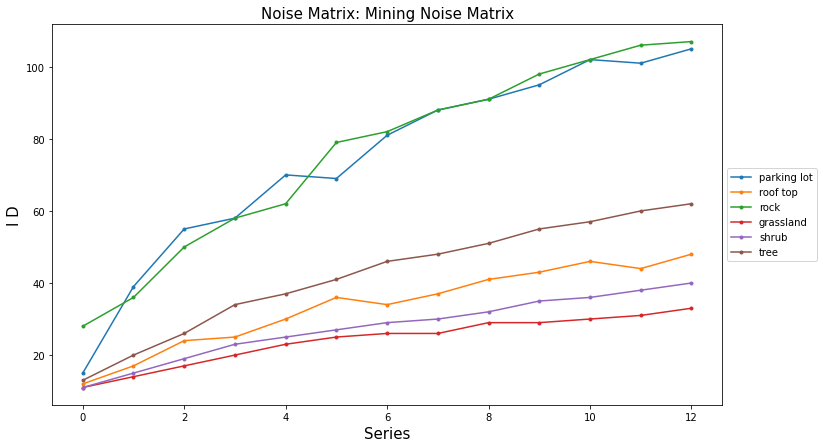

In [41]:
figure= plt.figure(figsize=(12, 7))

plt.plot([i['intrinsic_dimension'] for i in parking_lot_id_mining_noise_norm], marker='.', label='parking lot');
plt.plot([i['intrinsic_dimension'] for i in roof_top_id_mining_noise_norm], marker='.', label='roof top');
plt.plot([i['intrinsic_dimension'] for i in rock_id_mining_noise_norm], marker='.', label='rock');
plt.plot([i['intrinsic_dimension'] for i in grassland_id_mining_noise_norm], marker='.', label='grassland');
plt.plot([i['intrinsic_dimension'] for i in shrub_id_mining_noise_norm], marker='.', label='shrub');
plt.plot([i['intrinsic_dimension'] for i in tree_id_mining_noise_norm], marker='.', label='tree');

plt.xlabel('Series', fontsize=15);
plt.ylabel('I D', fontsize=15);
plt.title("Noise Matrix: Mining Noise Matrix", fontsize=15);
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

In [46]:
# covariance matricies


In [26]:
with open("/home/makiper/Notebooks/true_rock_rfls_2_corrected.pickle", "rb") as f:
    rock_rfls =  pickle.load(f)
    
with open("/home/makiper/Notebooks/true_grassland_rfls.pickle", "rb") as f:
    grassland_rfls =  pickle.load(f)

In [27]:
band_ranges = [(1340, 1460), (1800, 2050), 2450, 400]
wl = np.array(WAVELENGTHS)
cond_1 = ((wl > band_ranges[0][0]) & (wl < band_ranges[0][1]))
cond_2 = ((wl > band_ranges[1][0]) & (wl < band_ranges[1][1]))
cond_3 = (wl > band_ranges[2])
cond_4 = (wl < band_ranges[3])
bad_indicies = np.where(cond_1 | cond_2 | cond_3 | cond_4)
good_indicies = [i for i in range(425) if i not in list(bad_indicies[0])]

In [40]:
total_rmax = 0
total_gmax = 0
total_rmin = 0
total_gmin = 0
for j, date in enumerate(list(grassland_rfls.keys())):
    r_rfl = rock_rfls[date].copy()
    g_rfl = grassland_rfls[date].copy()
    
    bad_rfls_r = [i for i in range(len(r_rfl)) if -9999 in list(r_rfl[i])]
    r_rfl = np.delete(r_rfl, bad_rfls_r, axis=0)
    
    bad_rfls_g = [i for i in range(len(g_rfl)) if -9999 in list(g_rfl[i])]
    g_rfl = np.delete(g_rfl, bad_rfls_g, axis=0)
    
    r_cov = np.cov(r_rfl, rowvar=False)
    r_cov[bad_indicies] = np.nan
    r_cov[:, bad_indicies] = np.nan
    
    g_cov = np.cov(g_rfl, rowvar=False)
    g_cov[bad_indicies] = np.nan
    g_cov[:, bad_indicies] = np.nan
    
    g_max, g_min = 0, 0
    for x in range(g_cov.shape[0]):
        for y in range(g_cov.shape[1]):
            if g_cov[x][y] > g_max:
                g_max = g_cov[x][y]
            if g_cov[x][y] < g_min:
                g_min = g_cov[x][y]
    if g_max > total_gmax:
        total_gmax = g_max
    if g_min < total_gmin:
        total_gmin = g_min
    
    r_max, r_min = 0, 0
    for x in range(r_cov.shape[0]):
        for y in range(r_cov.shape[1]):
            if r_cov[x][y] > r_max:
                r_max = r_cov[x][y]
            if r_cov[x][y] < r_min:
                r_min = r_cov[x][y]
    if r_min < total_rmin:
        total_rmin = r_min
    if r_max < total_rmax:
        total_rmax = r_max
        
total_rmax, total_rmin, total_gmax, total_gmin

(0, 0, 0.011991170339353034, 0)

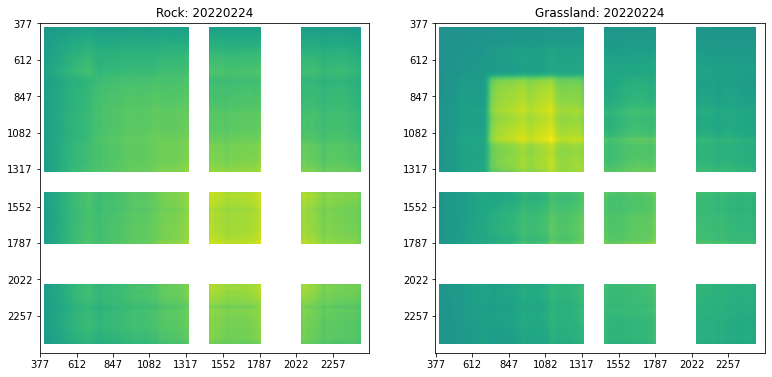

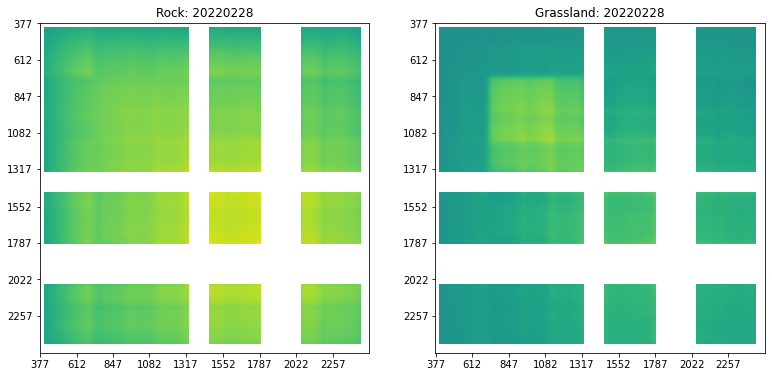

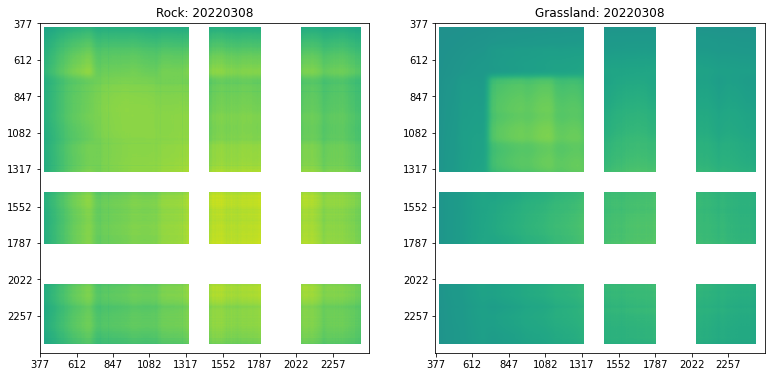

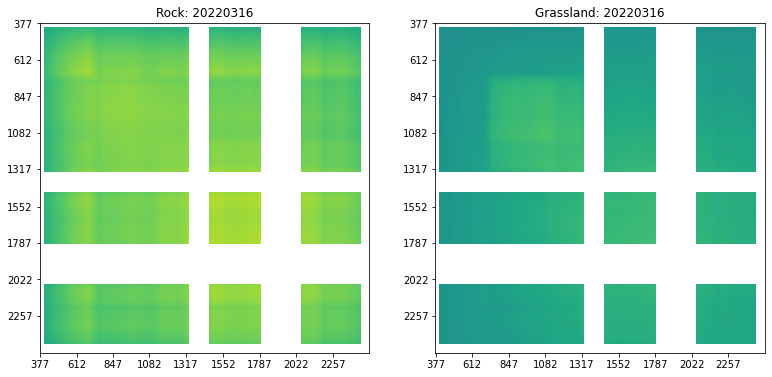

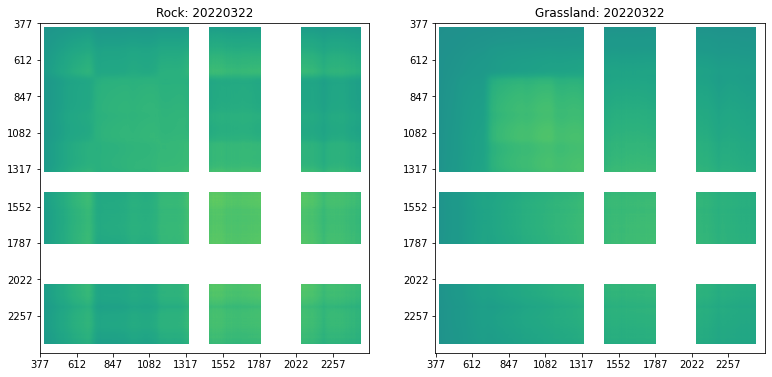

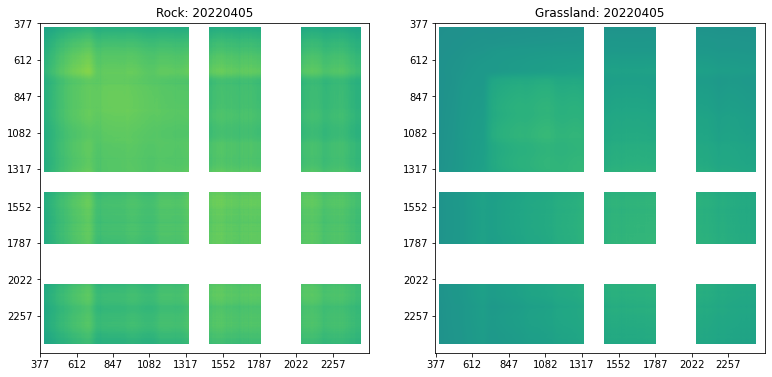

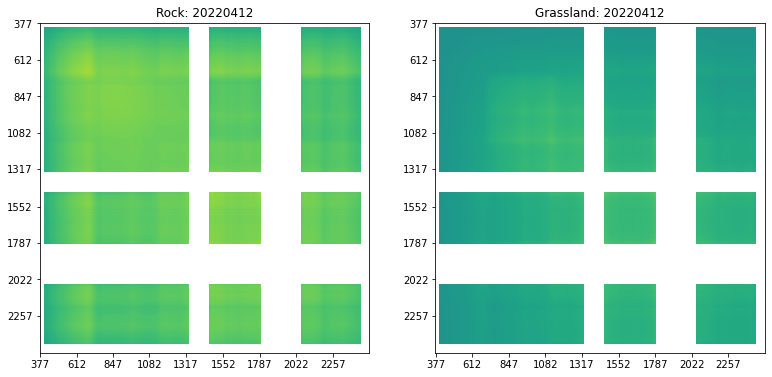

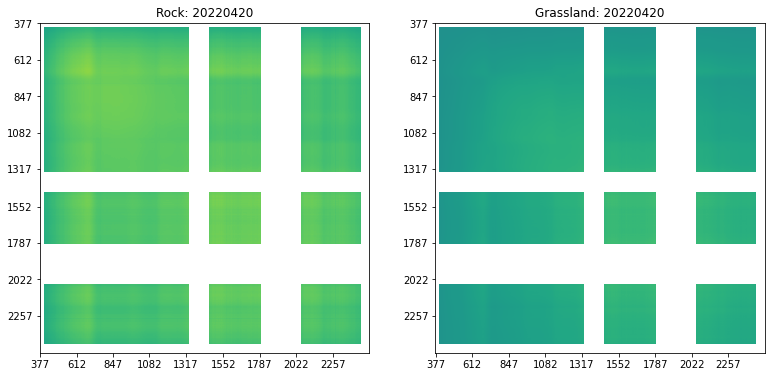

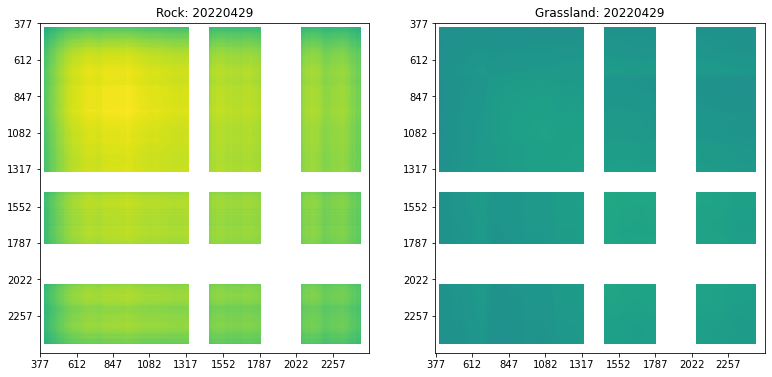

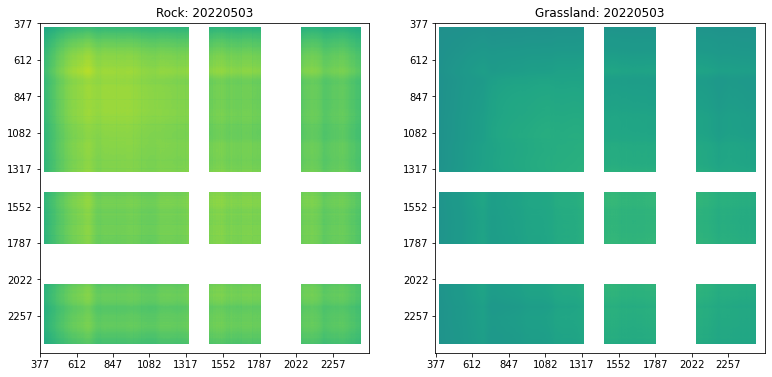

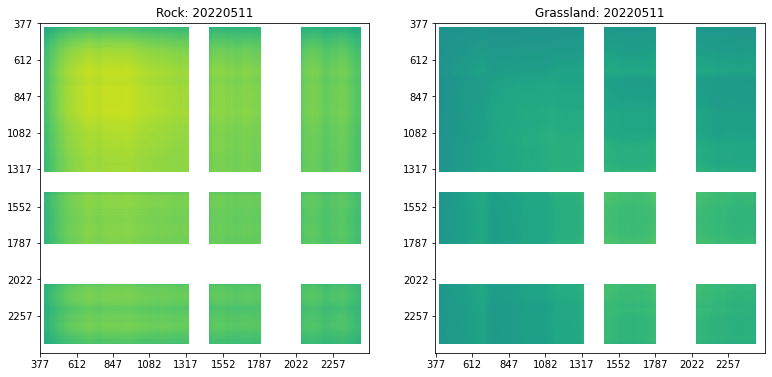

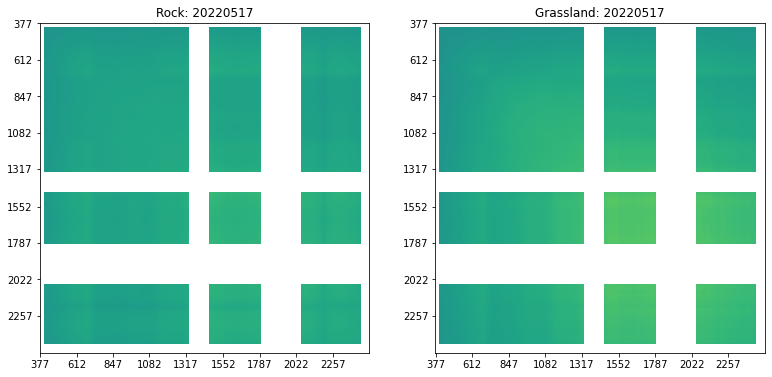

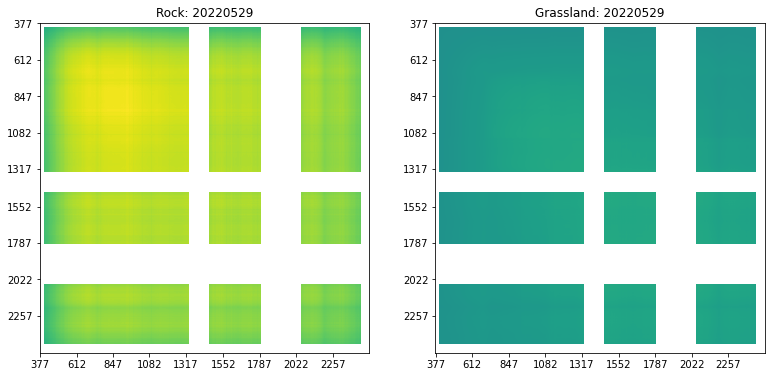

In [38]:
min_w, max_w = min(WAVELENGTHS), max(WAVELENGTHS)
ticks = [int(min_w+int((max_w-min_w)/9)*i) for i in range(9)] + [int(max_w)]

for j, date in enumerate(list(grassland_rfls.keys())):
    r_rfl = rock_rfls[date].copy()
    g_rfl = grassland_rfls[date].copy()
    
    bad_rfls_r = [i for i in range(len(r_rfl)) if -9999 in list(r_rfl[i])]
    r_rfl = np.delete(r_rfl, bad_rfls_r, axis=0)
    
    bad_rfls_g = [i for i in range(len(g_rfl)) if -9999 in list(g_rfl[i])]
    g_rfl = np.delete(g_rfl, bad_rfls_g, axis=0)
    
    r_cov = np.cov(r_rfl, rowvar=False)
    r_cov[bad_indicies] = np.nan
    r_cov[:, bad_indicies] = np.nan
    
    g_cov = np.cov(g_rfl, rowvar=False)
    g_cov[bad_indicies] = np.nan
    g_cov[:, bad_indicies] = np.nan
    
    fig1 = plt.figure(figsize=(13, 13));
    ax1 = fig1.add_subplot(1,2,1);
    ax1.set_title("Rock: "+date, fontsize=12);
    ax1.set_xticks([int(i) for i in np.linspace(0, 425, 10)], ticks);
    ax1.set_yticks([int(i) for i in np.linspace(0, 425, 10)], ticks);
    ax1.imshow(r_cov, vmin=-0.03542564224849031, vmax=0.03542564224849031);
    
    ax2 = fig1.add_subplot(1,2,2);
    ax2.set_title("Grassland: "+date, fontsize=12);
    ax2.set_xticks([int(i) for i in np.linspace(0, 425, 10)], ticks);
    ax2.set_yticks([int(i) for i in np.linspace(0, 425, 10)], ticks);
    ax2.imshow(g_cov, vmin=-0.011991170339353034, vmax=0.011991170339353034);


In [14]:
test_noise = np.genfromtxt('test_noise_mat.csv', delimiter=',')
test_noise[indicies] = np.nan

In [ ]:
    
with open("SHIFT_noise_M_allbands.txt", "rb") as f:
    old_noise = f.read()
    old_noise = str(old_noise).replace("b","").replace("'", "")
    old_noise = np.array([float(i) for i in str(old_noise).split(",") if i != ''])
    old_noise[indicies] = np.nan

In [10]:
band_ranges = [(1340, 1460), (1800, 2050), 2450, 400]
wl = np.array(WAVELENGTHS)
cond_1 = ((wl > band_ranges[0][0]) & (wl < band_ranges[0][1]))
cond_2 = ((wl > band_ranges[1][0]) & (wl < band_ranges[1][1]))
cond_3 = (wl > band_ranges[2])
cond_4 = (wl < band_ranges[3])
indicies = np.where(cond_1 | cond_2 | cond_3 | cond_4)

with open("SHIFT_noise_M_allbands_2.txt", "rb") as f:
    new_noise = f.read()
    new_noise = str(new_noise).replace("b","").replace("'", "")
    new_noise = np.array([float(i) for i in str(new_noise).split(",") if i != ''])
    new_noise[indicies] = np.nan
    
with open("SHIFT_noise_M_allbands.txt", "rb") as f:
    old_noise = f.read()
    old_noise = str(old_noise).replace("b","").replace("'", "")
    old_noise = np.array([float(i) for i in str(old_noise).split(",") if i != ''])
    old_noise[indicies] = np.nan

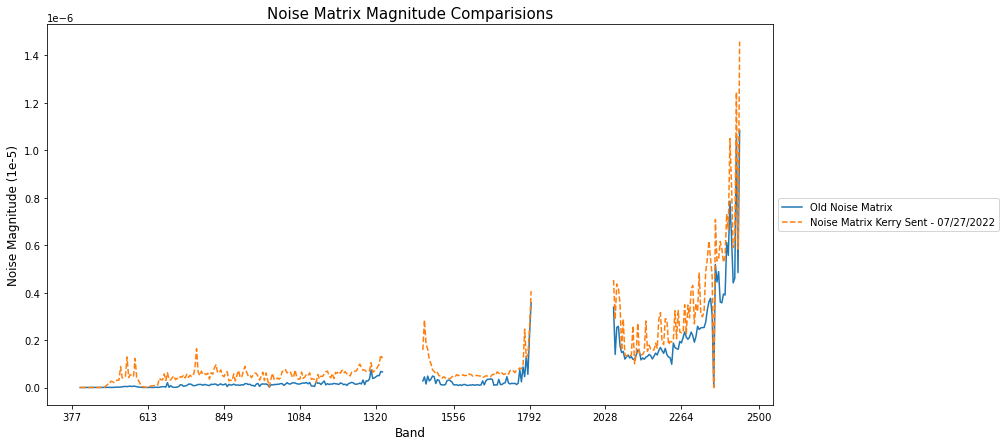

In [25]:
fig = plt.figure(figsize=(13,7))
# plt.plot(new_noise, label='New Noise Matrix');
plt.plot(old_noise, label='Old Noise Matrix');
plt.plot(test_noise, label="Noise Matrix Kerry Sent - 07/27/2022", linestyle="--");
plt.title("Noise Matrix Magnitude Comparisions", fontsize=15);
plt.xlabel("Band", fontsize=12);
plt.ylabel("Noise Magnitude (1e-5)", fontsize=12);
n = 10
x_t1 = [int(i) for i in np.linspace(np.array(WAVELENGTHS)[0], np.array(WAVELENGTHS)[-1], n)]
x_t0 = [int(i) for i in np.linspace(0, 425, 10)]
plt.xticks(x_t0, x_t1)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

In [11]:
new_noise[5]/old_noise[5], new_noise[6]/old_noise[6]

(152260900.77157724, 37411.86754540331)

/tmp/ipykernel_451004/3462738439.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  plt.plot([np.log10(new_noise[i]/old_noise[i]) for i in range(len(old_noise))], label='Log New Noise Magnitude');


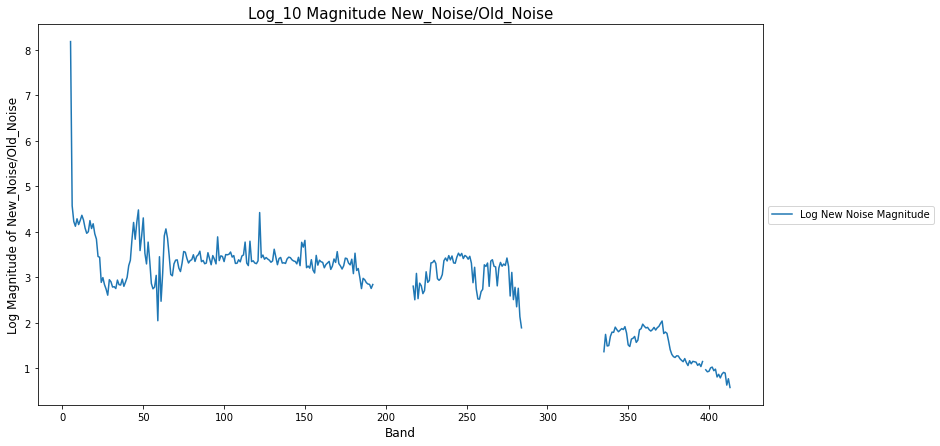

In [12]:
fig = plt.figure(figsize=(13,7))
plt.plot([np.log10(new_noise[i]/old_noise[i]) for i in range(len(old_noise))], label='Log New Noise Magnitude');
plt.title("Log_10 Magnitude New_Noise/Old_Noise", fontsize=15);
plt.xlabel("Band", fontsize=12);
plt.ylabel("Log Magnitude of New_Noise/Old_Noise", fontsize=12);
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

In [8]:
with open("whole_scene_new_noise_2.pickle", "rb") as f:
    whole_scene_id = pickle.load(f)

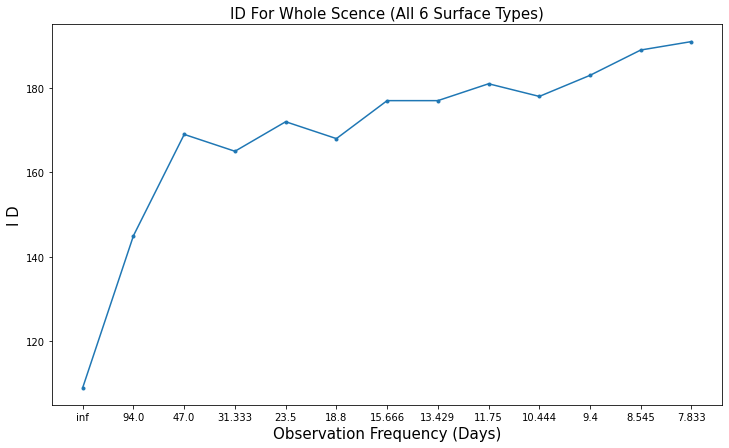

In [9]:
fig = plt.figure(figsize=(12, 7))
plt.plot([i['intrinsic_dimension'] for i in whole_scene_id], marker='.');
plt.title("ID For Whole Scence (All 6 Surface Types)", fontsize=15);
avg_resampling_periods = [np.inf, 94.0, 47.0, 31.333, 23.5, 18.8, 15.666, 13.429, 11.75, 10.444, 9.4, 8.545, 7.833]
plt.xticks([i for i in range(13)], avg_resampling_periods);
plt.xlabel("Observation Frequency (Days)", fontsize=15);
plt.ylabel("I D", fontsize=15);

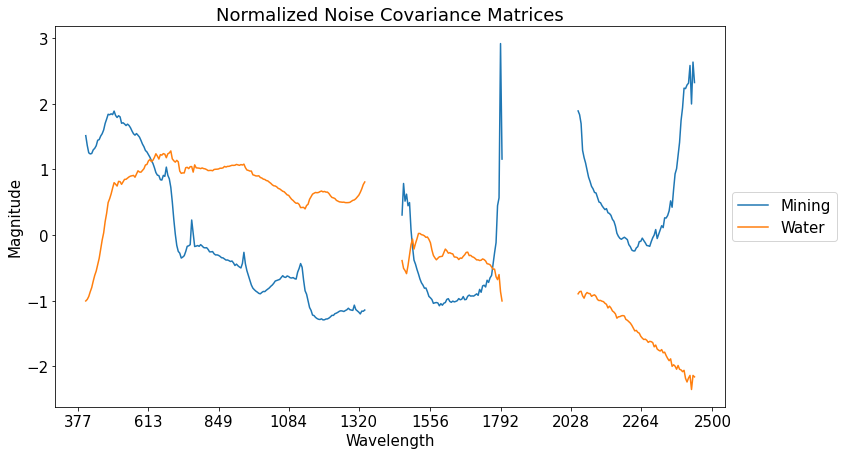

In [8]:
from visuals import *

band_ranges = [(1340, 1460), (1800, 2050), 2450, 400]
wl = np.array(WAVELENGTHS)
cond_1 = ((wl > band_ranges[0][0]) & (wl < band_ranges[0][1]))
cond_2 = ((wl > band_ranges[1][0]) & (wl < band_ranges[1][1]))
cond_3 = (wl > band_ranges[2])
cond_4 = (wl < band_ranges[3])
bad_indices = list(np.where(cond_1 | cond_2 | cond_3 | cond_4)[0])
indices = [i for i in range(425) if i not in bad_indices]
        
with open("/home/makiper/Notebooks/mining_noise_2.pickle", "rb") as f:
    m_noise = pickle.load(f)
m_noise_mat = m_noise

m_plot_elements = []
noise_index = 0
for i in range(425):
    if i in indices:
        m_plot_elements.append(np.diag(m_noise_mat)[noise_index])
        noise_index+=1
    else:
        m_plot_elements.append(np.nan)
        

with open("/home/makiper/Notebooks/water_noise.pickle", "rb") as f:
    w_noise = pickle.load(f)
w_noise_mat = w_noise

w_plot_elements = []
noise_index = 0
for i in range(425):
    if i in indices:
        w_plot_elements.append(w_noise_mat[noise_index])
        noise_index+=1
    else:
        w_plot_elements.append(np.nan)
        
n = 10
x_t1 = [int(i) for i in np.linspace(np.array(WAVELENGTHS)[0], np.array(WAVELENGTHS)[-1], n)]
x_t0 = [int(i) for i in np.linspace(0, 425, 10)]

fig = plt.figure(figsize=(12,7))
plt.plot([(i-np.nanmean(m_plot_elements))/np.nanstd(m_plot_elements) for i in m_plot_elements], label= "Mining");
plt.plot([(i-np.nanmean(w_plot_elements))/np.nanstd(w_plot_elements) for i in w_plot_elements], label= "Water");
# plt.plot(np.array(m_plot_elements)*10, label= "Mining 10x");
# plt.plot(np.array(m_plot_elements)*100, label= "Mining 100x");
plt.xticks(x_t0, x_t1)
plt.title("Normalized Noise Covariance Matrices", fontsize=18);
plt.xlabel("Wavelength", fontsize=15);
plt.ylabel("Magnitude", fontsize=15);
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15);

In [45]:
with open("true_parking_lot_3_rfls_rm_outliers.pickle", 'rb') as f:
    parking_lot_ids = pickle.load(f)
    
with open("true_roof_top_2_rfls_rm_outliers.pickle", 'rb') as f:
    roof_top_ids = pickle.load(f)
    
with open("true_rock_rfls_rm_outliers.pickle", 'rb') as f:
    rock_ids = pickle.load(f)
    
with open("true_grassland_rfls.pickle", 'rb') as f:
    grassland_ids = pickle.load(f)
    
with open("true_shrub_rfls.pickle", 'rb') as f:
    shrub_ids = pickle.load(f)
    
with open("true_tree_rfls.pickle", 'rb') as f:
    tree_ids = pickle.load(f)

In [38]:
band_ranges = [(1340, 1460), (1800, 2050), 2450, 400]
wl = np.array(WAVELENGTHS)
cond_1 = ((wl > band_ranges[0][0]) & (wl < band_ranges[0][1]))
cond_2 = ((wl > band_ranges[1][0]) & (wl < band_ranges[1][1]))
cond_3 = (wl > band_ranges[2])
cond_4 = (wl < band_ranges[3])
bad_indices = list(np.where(cond_1 | cond_2 | cond_3 | cond_4)[0])
indices = [i for i in range(425) if i not in bad_indices]

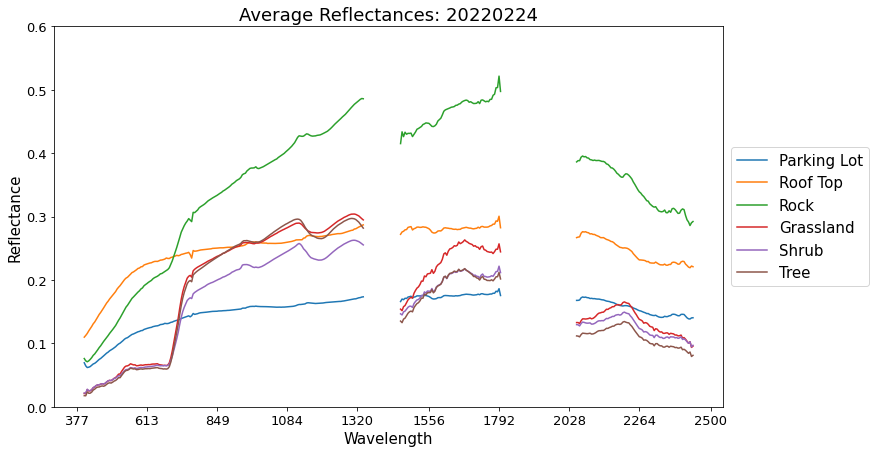

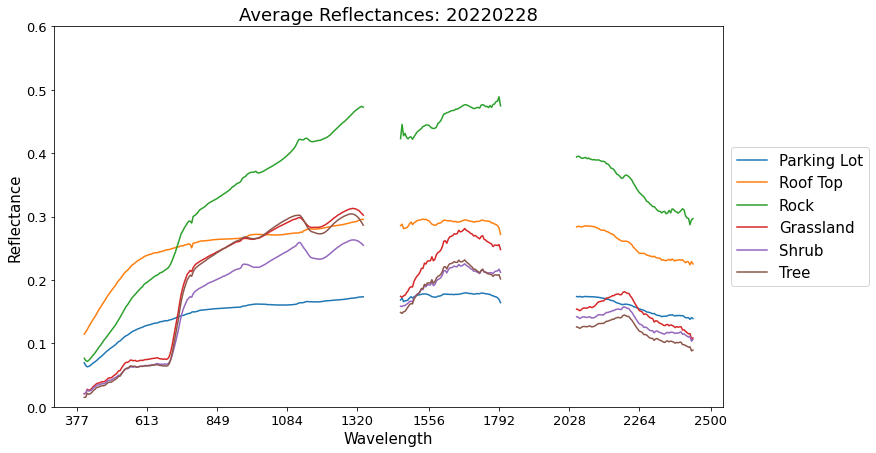

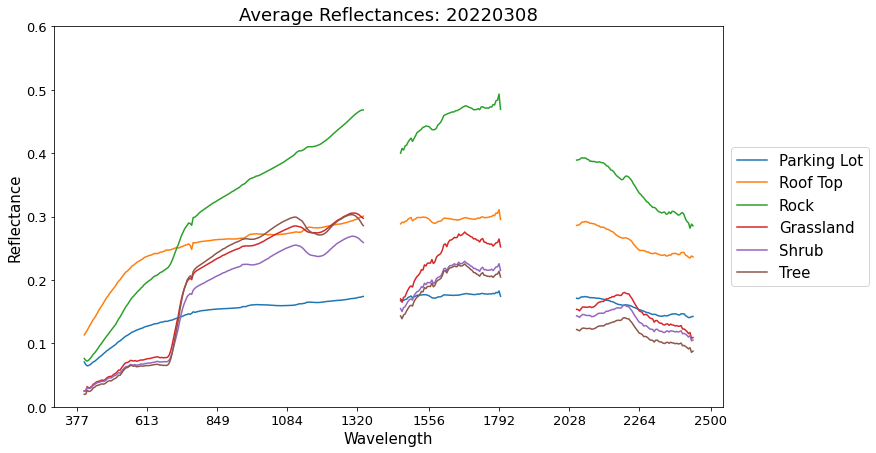

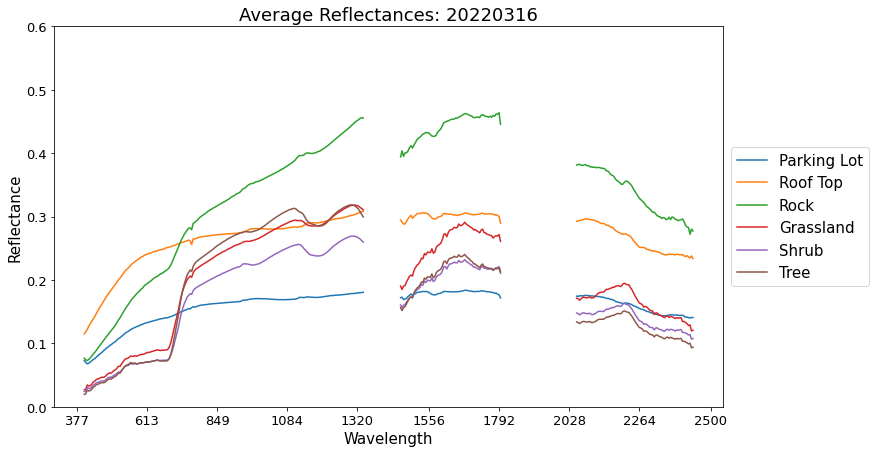

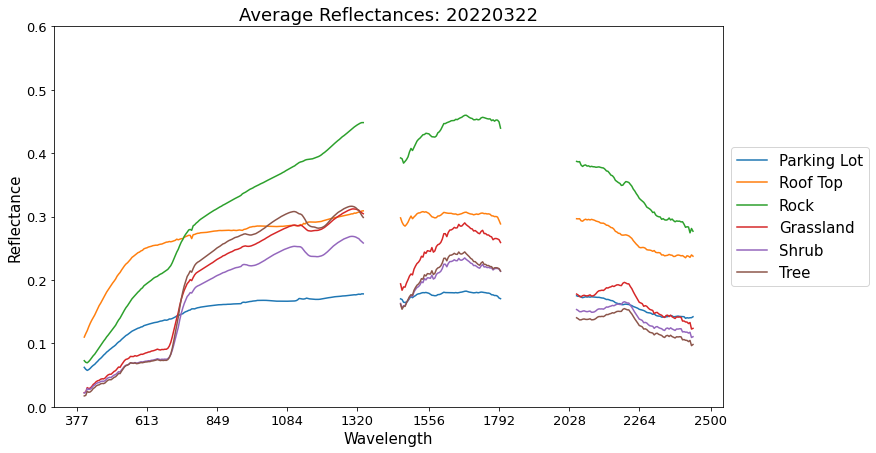

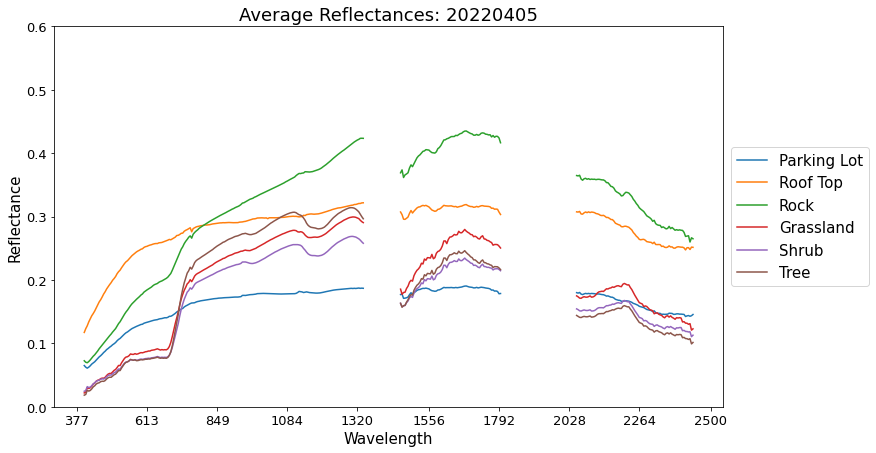

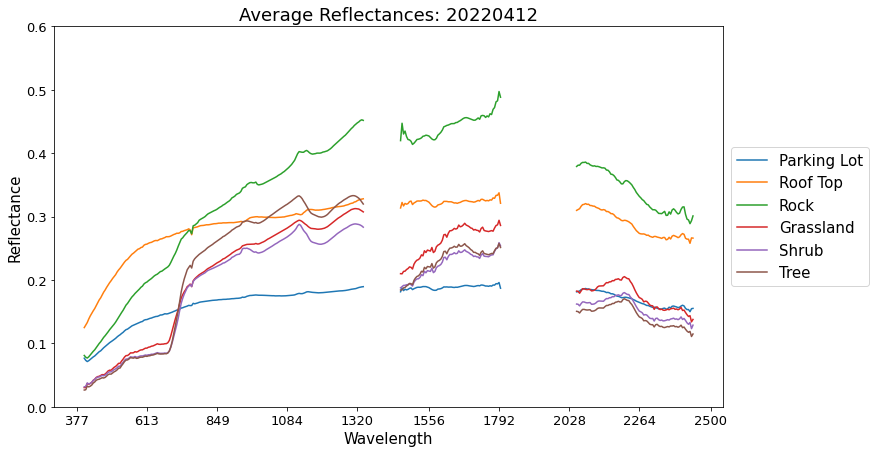

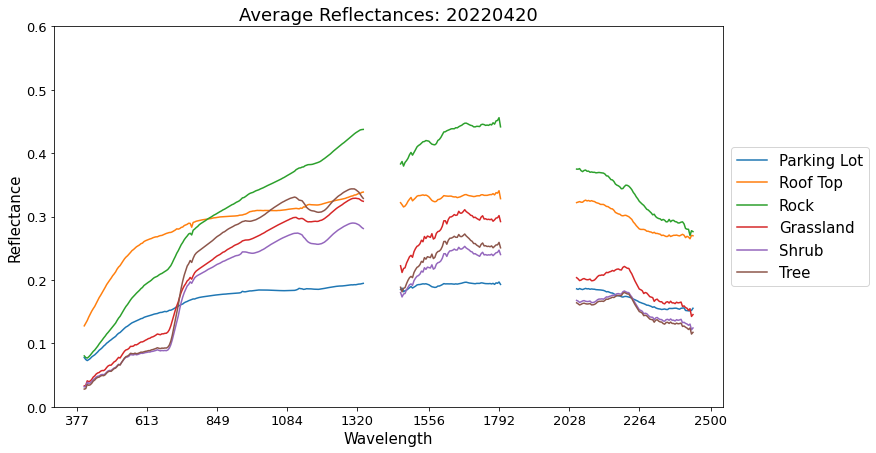

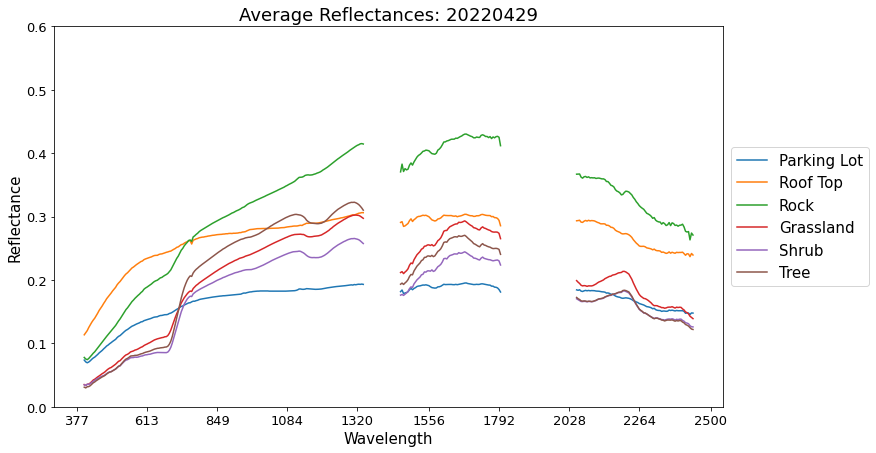

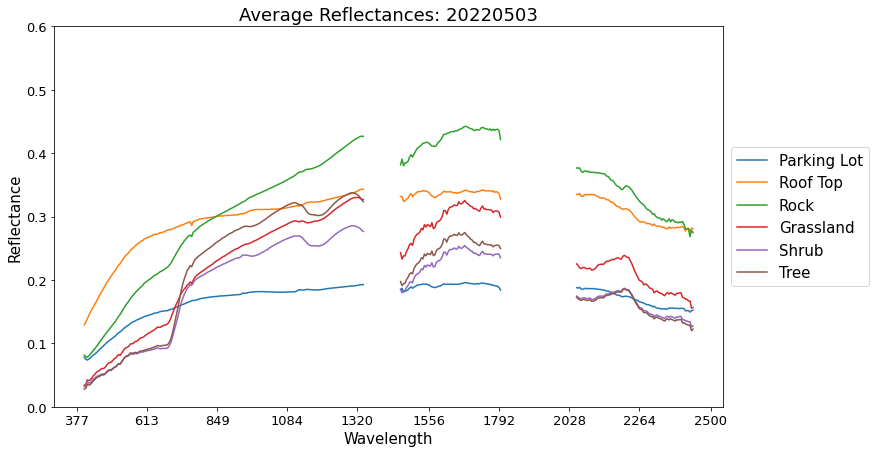

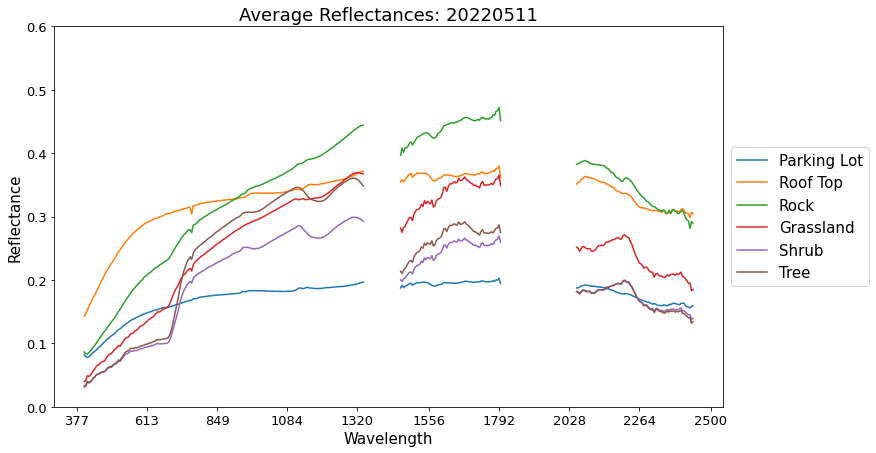

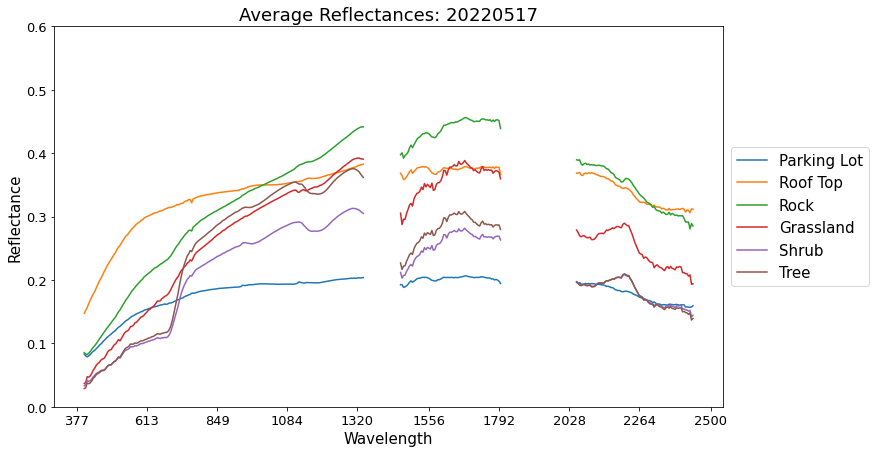

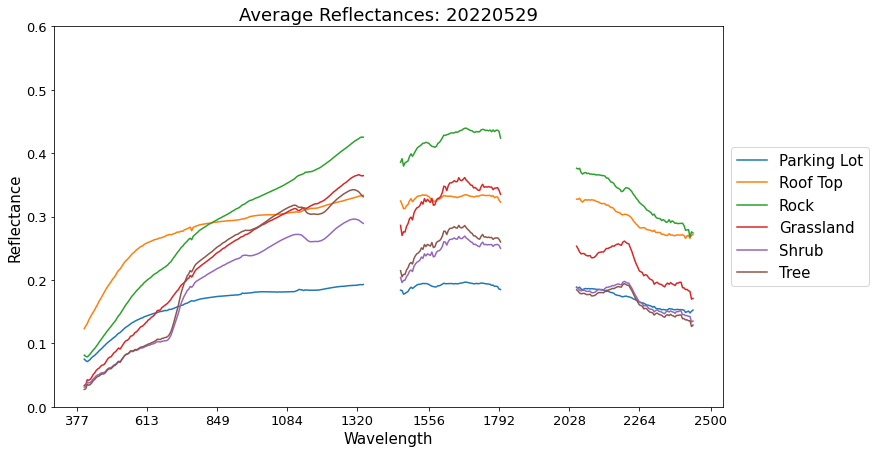

In [54]:
colors = plt.cm.coolwarm(np.linspace(0,1,len(threshes)))
parking_lot_colors = plt.cm.get_cmap("Blues", 10)

for date in parking_lot_ids.keys():
    fig = plt.figure(figsize=(12, 7))
    parking_lot_ids[date][:, bad_indices] = np.nan
    parking_lot_ids[date] = np.array([i for i in parking_lot_ids[date] if -9999 not in list(i)])
    
    roof_top_ids[date][:, bad_indices] = np.nan
    roof_top_ids[date] = np.array([i for i in roof_top_ids[date] if -9999 not in list(i)])
    
    rock_ids[date][:, bad_indices] = np.nan
    rock_ids[date] = np.array([i for i in rock_ids[date] if -9999 not in list(i)])
    
    grassland_ids[date][:, bad_indices] = np.nan
    grassland_ids[date] = np.array([i for i in grassland_ids[date] if -9999 not in list(i)])
    
    shrub_ids[date][:, bad_indices] = np.nan
    shrub_ids[date] = np.array([i for i in shrub_ids[date] if -9999 not in list(i)])
    
    tree_ids[date][:, bad_indices] = np.nan
    tree_ids[date] = np.array([i for i in tree_ids[date] if -9999 not in list(i)])
    
    plt.plot(np.mean(parking_lot_ids[date], axis=0), label='Parking Lot');
    plt.plot(np.mean(roof_top_ids[date], axis=0), label='Roof Top');
    plt.plot(np.mean(rock_ids[date], axis=0), label='Rock');
    plt.plot(np.mean(grassland_ids[date], axis=0), label='Grassland');
    plt.plot(np.mean(shrub_ids[date], axis=0), label=f'Shrub');
    plt.plot(np.mean(tree_ids[date], axis=0), label='Tree');
    
    plt.ylim(0, 0.6);
    n = 10
    x_t1 = [int(i) for i in np.linspace(np.array(WAVELENGTHS)[0], np.array(WAVELENGTHS)[-1], n)]
    x_t0 = [int(i) for i in np.linspace(0, 425, 10)]
    plt.xticks(x_t0, x_t1)
    plt.title(f"Average Reflectances: {str(date)}", fontsize=18);
    plt.ylabel("Reflectance", fontsize=15);
    plt.xlabel("Wavelength", fontsize=15);
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.legend(fontsize=15, loc='center left', bbox_to_anchor=(1, 0.5));
    
    plt.show();
    print("\n")

In [24]:
with open("true_grassland_rfls.pickle", "rb") as f:
    grassland_rfls = pickle.load(f)

In [27]:
with open("/home/makiper/Notebooks/mining_noise_2.pickle", "rb") as f:
    m_noise = pickle.load(f)
noise = np.diag(m_noise)
noise = {'noise_covariance':np.diag(noise), 'estimation_method': 'MultipleRegressionClassicNoiseEstimator'} 

In [32]:
band_ranges = [(1340, 1460), (1800, 2050), 2450, 400]
wl = np.array(WAVELENGTHS)
cond_1 = ((wl > band_ranges[0][0]) & (wl < band_ranges[0][1]))
cond_2 = ((wl > band_ranges[1][0]) & (wl < band_ranges[1][1]))
cond_3 = (wl > band_ranges[2])
cond_4 = (wl < band_ranges[3])
bad_indices = list(np.where(cond_1 | cond_2 | cond_3 | cond_4)[0])
indices = [i for i in range(425) if i not in bad_indices]

In [36]:
ids = {}
for date, rfls in grassland_rfls.items():
    int_dim = ID()
    this_rfls = np.array(rfls)[:, indices]
    this_rfls = [i for i in this_rfls if -9999 not in list(i)]
    this_rfls = [r/(sum([i**2 for i in r])**0.5) for r in this_rfls]
    id_ = int_dim(np.array(this_rfls), noise)
    ids[date] = id_
    print(date)

20220224
20220228
20220308
20220316
20220322
20220405
20220412
20220420
20220429
20220503
20220511
20220517
20220529


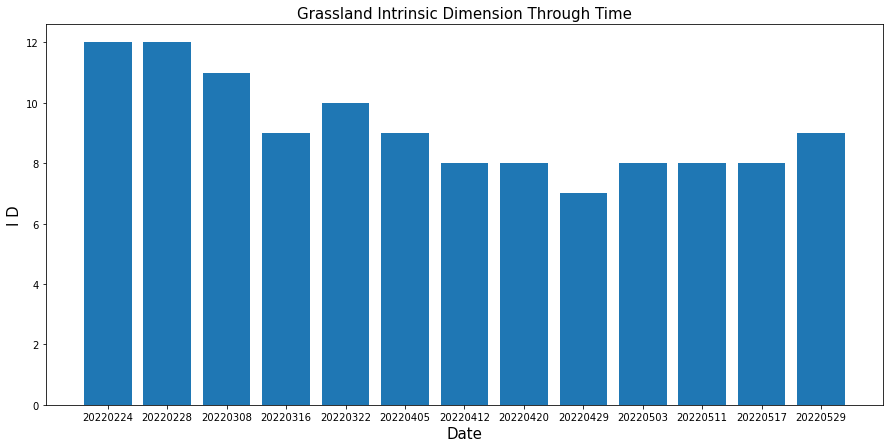

In [43]:
fig = plt.figure(figsize=(15, 7))
plt.bar(ids.keys(),[v['intrinsic_dimension'] for k,v in ids.items()]);
# plt.xitcks(fontsize=15);
# plt.yitcks(fontsize=15);
plt.xlabel("Date", fontsize=15);
plt.ylabel("I D", fontsize=15);
plt.title("Grassland Intrinsic Dimension Through Time", fontsize=15);